**3.3.2 간단한 분류 모델 구현하기**
- 지도학습의 분류(Classification)를 하는 인공 신경망 구현
- 0과 1로 된 정답을 가진 데이터셋을 생성하여, 신경망 모델에 학습
- 입력된 데이터를 0과 1 중 알맞은 카테고리 분류

In [18]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [19]:
# 신경망의 학습과 평가에 사용할 데이터셋 생성
# make_blobs() : 예제용 데이터셋을 만들어주는 함수이며, 실행마다 랜덤하게 생성
# n_samples : 표본 데이터 수
# n_features : 독립 변수 수
# centers : 클러스터 수 혹은 중심
# cluster_std: 클러스터 표준 편차
# shuffle : True는 숫자를 랜덤으로 섞어주는 역할
# x : [n_samples, n_features] 크기의 배열
# y : [n_samples] 크기의 배열
n_dim = 2  # 차원 설정
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[1,1], [-1,-1], [1,-1], [-1,1]],
                              shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                              centers=[[1,1], [-1,-1], [1,-1], [-1,1]],
                              shuffle=True, cluster_std=0.3)

In [20]:
# 학습 및 평가 데이터 shape 확인
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(80, 2)
(80,)
(20, 2)
(20,)


In [21]:
# 학습 및 평가 데이터 확인
print('x_train :', x_train[:5])
print('y_train :', y_train[:5])
print('x_test :', x_test[:5])
print('y_test :', y_test[:5])

x_train : [[-1.09051827  0.80708982]
 [ 0.71446535  1.42423152]
 [-1.10828486  1.58670855]
 [ 0.8288491  -0.73147436]
 [ 0.72468221 -1.24097582]]
y_train : [3 0 3 2 2]
x_test : [[-0.82262609 -1.11272455]
 [ 0.7614999  -0.86760186]
 [ 0.7272895  -0.42991903]
 [ 1.2269822  -1.2380466 ]
 [ 0.92739403  0.91145454]]
y_test : [1 2 2 2 0]


In [22]:
# label_map()이라는 함수를 구현해 0,1,2,3인 4개의 레이블을 2개로 합치기
def label_map(y_, from_, to_):
  y = numpy.copy(y_)
  for f in from_:
    y[y_ == f] = to_
  return y

# 0, 1 : 0
# 2, 3 : 1
y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

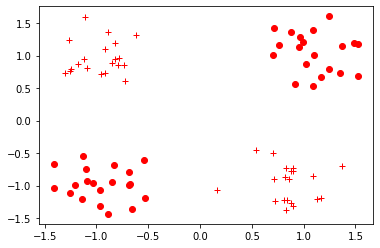

In [23]:
# 라벨링 된 데이터를 시각화하여 확인
def vis_data(x,y = None, c = 'r'):
  if y is None:
    y = [None] * len(x)
  for x_, y_ in zip(x,y):
    if y_ is None:
      plt.plot(x_[0], x_[1], '*', markerfacecolor='none',
               markeredgecolor=c)
    else:
      plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [24]:
# 넘파이 벡터 형식 데이터를 텐서로 변환
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [25]:
class NeuralNetwork(torch.nn.Module):                                   # 신경망 모듈(torch.nn.Module)을 상속 받는 파이썬 클래스 정의
  def __init__(self, input_size, hidden_size):                          # self, input_size, hidden_size를 입력 받도록 함
    super(NeuralNetwork, self).__init__()
    self.input_size = input_size                                        # 신경망에 입력되는 데이터의 차원
    self.hidden_size = hidden_size
    self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)  # wx + b 연산을 지원하는 객체를 반환
    self.relu = torch.nn.ReLU()                                         # 활성화 함수
    self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
    self.sigmoid = torch.nn.Sigmoid()                                   # 활성화 함수

  def forward(self, input_tensor):         # init() 함수에서 정의한 동작들을 차례대로 실행하는 foward() 함수 정의
    linear1 = self.linear_1(input_tensor)  # 입력 데이터에 input_size, hidden_size 크기의 가중치를 행렬곱하고 편향을 더해 [1,hidden_size] 텐서 반환
    relu = self.relu(linear1)              # linear1에 ReLU 활성화 함수 적용(입력값이 0보다 작으면 0, 0보다 크면 입력값 그대로 출력)
    linear2 = self.linear_2(relu)          # ReLU 함수를 통과한 텐서를 다시 행렬곱을 거쳐 [1,1] 반환
    output = self.sigmoid(linear2)         # 결과 값에 0과 1 사이의 값을 반환하기 위해 linear2를 Sigmoid 활성화 함수에 입력 
    return output

In [26]:
# 모델 생성 및 알고리즘 정의
model = NeuralNetwork(2, 5)                                         # input_size = 2, hidden_size = 5 설정
learning_rate = 0.03                                                # 학습률 설정
criterion = torch.nn.BCELoss()                                      # 오차함수 : BCELoss(이진 교차 엔트로피(Binary Cross Entropy)
epochs = 2000                                                       # 전체 학습 데이터를 모델에 2000번 입력
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # 최적화 알고리즘(확률적 경사하강법, SGD)

In [27]:
# 신경망 학습 전, 모델의 성능 테스트
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)   # x_test의 차원을 squeeze() 함수로 줄여서 y_test 차원에 맞추기
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7075004577636719


In [28]:
# 신경망 학습하기
for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()
  train_output = model(x_train)
  train_loss = criterion(train_output.squeeze(), y_train)
  if epoch % 100 == 0:
    print('Train loss at {} is {}'.format(epoch, train_loss.item()))
  train_loss.backward()
  optimizer.step()

Train loss at 0 is 0.7151814699172974
Train loss at 100 is 0.6695715188980103
Train loss at 200 is 0.6269829869270325
Train loss at 300 is 0.5829985737800598
Train loss at 400 is 0.533379852771759
Train loss at 500 is 0.47655361890792847
Train loss at 600 is 0.41204434633255005
Train loss at 700 is 0.3451598882675171
Train loss at 800 is 0.28053900599479675
Train loss at 900 is 0.22896599769592285
Train loss at 1000 is 0.19003881514072418
Train loss at 1100 is 0.16025087237358093
Train loss at 1200 is 0.13688817620277405
Train loss at 1300 is 0.11879192292690277
Train loss at 1400 is 0.10461090505123138
Train loss at 1500 is 0.09306430071592331
Train loss at 1600 is 0.08359453082084656
Train loss at 1700 is 0.07595431804656982
Train loss at 1800 is 0.06949790567159653
Train loss at 1900 is 0.06401842832565308


In [29]:
# 신경망 학습 후, 모델의 성능 테스트
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.07282355427742004


In [30]:
# sate_dict() 함수를 통해 모델 내 가중치들을 딕셔너리 형태로 표현
# 모델 내 가중치들을 model.pt로 저장
torch.save(model.state_dict(), './model.pt')
print('sate_dict format of the model: {}'.format(model.state_dict()))

sate_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 1.4635, -2.2178],
        [ 0.0618, -0.6271],
        [-0.6381, -0.8241],
        [-1.3143, -1.5543],
        [-1.8235,  0.8696]])), ('linear_1.bias', tensor([-0.4066, -0.1211, -0.2990, -0.0568,  0.4092])), ('linear_2.weight', tensor([[ 2.5902,  0.0112, -0.7250, -1.8866,  1.9190]])), ('linear_2.bias', tensor([-1.9104]))])


In [31]:
# 저장한 model.pt를 불러 가중치를 새로운 모델에 곧바로 적용
new_model = NeuralNetwork(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1,1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1,1]이 레이블 1을 가질 확률은 0.9827616810798645
